In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from matplotlib.dates import DayLocator, DateFormatter, date2num
from matplotlib.ticker import FuncFormatter
from matplotlib import rc
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet
import chart_studio
import chart_studio.plotly as py

In [2]:
chart_studio.tools.set_credentials_file(username='ralhusban', api_key='0F7vaylJaEkkbwUk3SLi')
chart_studio.tools.set_config_file(world_readable=True,
                             sharing='public')

In [3]:
import dash
import dash_core_components as dcc
import dash_html_components as html

## Import dataset from the Government of Ontario
The advantage of importing a dataset directly from a URL is that you'll always get an up to date infromation on COVID-19

In [4]:
Ontario_data=pd.read_csv('https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtesting.csv', parse_dates=True)
Ontario_clinic_data=pd.read_csv('https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv', parse_dates=True)

In [5]:
Ontario_confirmed_df=Ontario_data

In [6]:
Ontario_confirmed_df.index=Ontario_confirmed_df['Reported Date'] # Making the date our index to facilitate working with the dataset as a time series

In [7]:
Ontario_confirmed_df.rename(columns={'Total Cases':'Cumulative_cases', 'Deaths':'Cumulative_deaths'}, inplace=True) # Making sure there are no spaces in column names

In [8]:
Ontario_confirmed_df.index=pd.to_datetime(Ontario_confirmed_df.index) # Converting Dtype to Date

In [9]:
Ontario_confirmed_df['New_cases']=Ontario_confirmed_df['Cumulative_cases'].diff() #Diff() calculates difference from previous rows
Ontario_confirmed_df['New_deaths']=Ontario_confirmed_df['Cumulative_deaths'].diff()

## Below we calculate 3-day and 7-day rolling averages which are important metrics in epidemiology. They absorb daily fluctuations in daily numbers and show the general trend

In [10]:
Ontario_confirmed_df['New_cases_MA3']=Ontario_confirmed_df['New_cases'].rolling(window=3).mean()
Ontario_confirmed_df['New_cases_MA7']=Ontario_confirmed_df['New_cases'].rolling(window=7).mean()
Ontario_confirmed_df['New_deaths_MA3']=Ontario_confirmed_df['New_deaths'].rolling(window=3).mean()
Ontario_confirmed_df['New_deaths_MA7']=Ontario_confirmed_df['New_deaths'].rolling(window=7).mean()
Ontario_confirmed_df['Hosp_MA3']=Ontario_confirmed_df['Number of patients hospitalized with COVID-19'].rolling(window=3).mean()
Ontario_confirmed_df['ICU_MA3']=Ontario_confirmed_df['Number of patients in ICU with COVID-19'].rolling(window=3).mean()
Ontario_confirmed_df['Ventilator_MA3']=Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'].rolling(window=3).mean()

In [11]:
Ontario_confirmed_df=Ontario_confirmed_df.iloc[28:] # The first 28 days have little useful data as cases were very low

In [12]:
Ontario_confirmed_df

Reported Date  Confirmed Negative  Presumptive Negative  \
Reported Date                                                           
2020-03-05       2020-03-05              1466.0                   NaN   
2020-03-06       2020-03-06              1665.0                   NaN   
2020-03-07       2020-03-07              1918.0                   NaN   
2020-03-08       2020-03-08              2094.0                   NaN   
2020-03-09       2020-03-09              2347.0                   NaN   
...                     ...                 ...                   ...   
2020-08-09       2020-08-09                 NaN                   NaN   
2020-08-10       2020-08-10                 NaN                   NaN   
2020-08-11       2020-08-11                 NaN                   NaN   
2020-08-12       2020-08-12                 NaN                   NaN   
2020-08-13       2020-08-13                 NaN                   NaN   

               Presumptive Positive  Confirmed Positive  Resolved  \
Reported Date                                                       
2020-03-05                      NaN                18.0       4.0   
2020-03-06                      NaN                22.0       4.0   
2020-03-07                      NaN                24.0       4.0   
2020-03-08                      NaN                25.0       4.0   
2020-03-09                      NaN                31.0       4.0   
...                             ...                 ...       ...   
2020-08-09                      NaN               981.0   36279.0   
2020-08-10                      NaN               994.0   36381.0   
2020-08-11                      NaN               952.0   36456.0   
2020-08-12                      NaN               912.0   36590.0   
2020-08-13                      NaN               891.0   36689.0   

               Cumulative_deaths  Cumulative_cases  \
Reported Date                                        
2020-03-05                   NaN              22.0   
2020-03-06                   NaN              26.0   
2020-03-07                   NaN              28.0   
2020-03-08                   NaN              29.0   
2020-03-09                   NaN              35.0   
...                          ...               ...   
2020-08-09                2786.0           40046.0   
2020-08-10                2786.0           40161.0   
2020-08-11                2786.0           40194.0   
2020-08-12                2787.0           40289.0   
2020-08-13                2787.0           40367.0   

               Total patients approved for testing as of Reporting Date  \
Reported Date                                                             
2020-03-05                                                1566.0          
2020-03-06                                                1763.0          
2020-03-07                                                1982.0          
2020-03-08                                                2178.0          
2020-03-09                                                2404.0          
...                                                          ...          
2020-08-09                                             2400212.0          
2020-08-10                                             2422487.0          
2020-08-11                                             2444068.0          
2020-08-12                                             2468640.0          
2020-08-13                                             2498266.0          

               Total tests completed in the last day  ...  \
Reported Date                                         ...   
2020-03-05                                       NaN  ...   
2020-03-06                                       NaN  ...   
2020-03-07                                       NaN  ...   
2020-03-08                                       NaN  ...   
2020-03-09                                       NaN  ...   
...                                              ...  ...   

## Below plot with MATPLOTLIB for hospitalization in Ontario. Note how we define text position using date to set the X axis and the number of cases to set the Y-axis

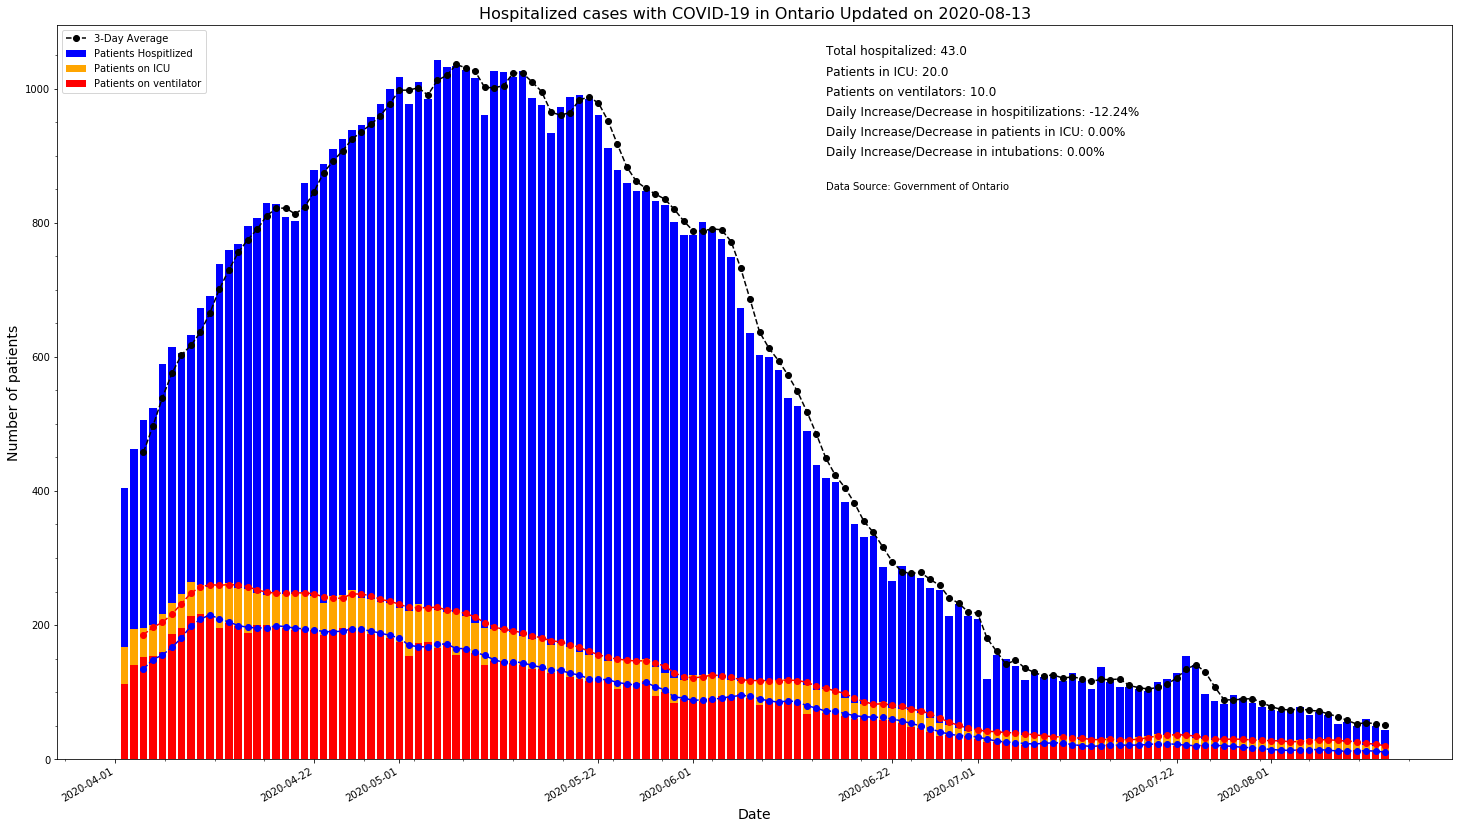

In [13]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients hospitalized with COVID-19'], label='Patients Hospitlized', color='blue')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Hosp_MA3'], 'ko--', label='3-Day Average')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients in ICU with COVID-19'], label='Patients on ICU', color='orange')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['ICU_MA3'], 'ro--')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'], label='Patients on ventilator', color='red')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Ventilator_MA3'], 'bo--')
ax.text(x=dt.datetime(2020,6,15), y=1050,s='Total hospitalized: '+str(Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=1020,s='Patients in ICU: '+str(Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=990,s='Patients on ventilators: '+str(Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=960,s='Daily Increase/Decrease in hospitilizations: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-1]-Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-2])/Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-2]*100))+'%', fontsize=12) # Note the use of the format() method to round the percentage decimals
ax.text(x=dt.datetime(2020,6,15), y=930,s='Daily Increase/Decrease in patients in ICU: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-1]-Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-2])/Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-2]*100))+'%', fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=900,s='Daily Increase/Decrease in intubations: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-1]-Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-2])/Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-2]*100))+'%', fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=850,s='Data Source: Government of Ontario')
plt.legend(loc='upper left')
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)
plt.title('Hospitalized cases with COVID-19 in Ontario Updated on '+ str(dt.date.today()) , fontsize=16)
plt.minorticks_on()
plt.show()

## Testing data is an important metric for any Governmen to detect infection propagation trends. As done previously, note the various metrics generated in the plot

In [14]:
ON_testing_goal_met=0
for i in range(len(Ontario_confirmed_df)):
    if Ontario_confirmed_df['Total tests completed in the last day'][i]>16000:
        ON_testing_goal_met+=1

In [15]:
ON_testing_goal_met

83

In [46]:
ON_days_under_100_cases=0
for i in range(len(Ontario_confirmed_df)):
    if Ontario_confirmed_df['New_cases'][i]<100:
        ON_days_under_100_cases+=1

In [47]:
ON_days_under_100_cases

32

In [16]:
Ontario_confirmed_df

Reported Date  Confirmed Negative  Presumptive Negative  \
Reported Date                                                           
2020-03-05       2020-03-05              1466.0                   NaN   
2020-03-06       2020-03-06              1665.0                   NaN   
2020-03-07       2020-03-07              1918.0                   NaN   
2020-03-08       2020-03-08              2094.0                   NaN   
2020-03-09       2020-03-09              2347.0                   NaN   
...                     ...                 ...                   ...   
2020-08-09       2020-08-09                 NaN                   NaN   
2020-08-10       2020-08-10                 NaN                   NaN   
2020-08-11       2020-08-11                 NaN                   NaN   
2020-08-12       2020-08-12                 NaN                   NaN   
2020-08-13       2020-08-13                 NaN                   NaN   

               Presumptive Positive  Confirmed Positive  Resolved  \
Reported Date                                                       
2020-03-05                      NaN                18.0       4.0   
2020-03-06                      NaN                22.0       4.0   
2020-03-07                      NaN                24.0       4.0   
2020-03-08                      NaN                25.0       4.0   
2020-03-09                      NaN                31.0       4.0   
...                             ...                 ...       ...   
2020-08-09                      NaN               981.0   36279.0   
2020-08-10                      NaN               994.0   36381.0   
2020-08-11                      NaN               952.0   36456.0   
2020-08-12                      NaN               912.0   36590.0   
2020-08-13                      NaN               891.0   36689.0   

               Cumulative_deaths  Cumulative_cases  \
Reported Date                                        
2020-03-05                   NaN              22.0   
2020-03-06                   NaN              26.0   
2020-03-07                   NaN              28.0   
2020-03-08                   NaN              29.0   
2020-03-09                   NaN              35.0   
...                          ...               ...   
2020-08-09                2786.0           40046.0   
2020-08-10                2786.0           40161.0   
2020-08-11                2786.0           40194.0   
2020-08-12                2787.0           40289.0   
2020-08-13                2787.0           40367.0   

               Total patients approved for testing as of Reporting Date  \
Reported Date                                                             
2020-03-05                                                1566.0          
2020-03-06                                                1763.0          
2020-03-07                                                1982.0          
2020-03-08                                                2178.0          
2020-03-09                                                2404.0          
...                                                          ...          
2020-08-09                                             2400212.0          
2020-08-10                                             2422487.0          
2020-08-11                                             2444068.0          
2020-08-12                                             2468640.0          
2020-08-13                                             2498266.0          

               Total tests completed in the last day  ...  \
Reported Date                                         ...   
2020-03-05                                       NaN  ...   
2020-03-06                                       NaN  ...   
2020-03-07                                       NaN  ...   
2020-03-08                                       NaN  ...   
2020-03-09                                       NaN  ...   
...                                              ...  ...   

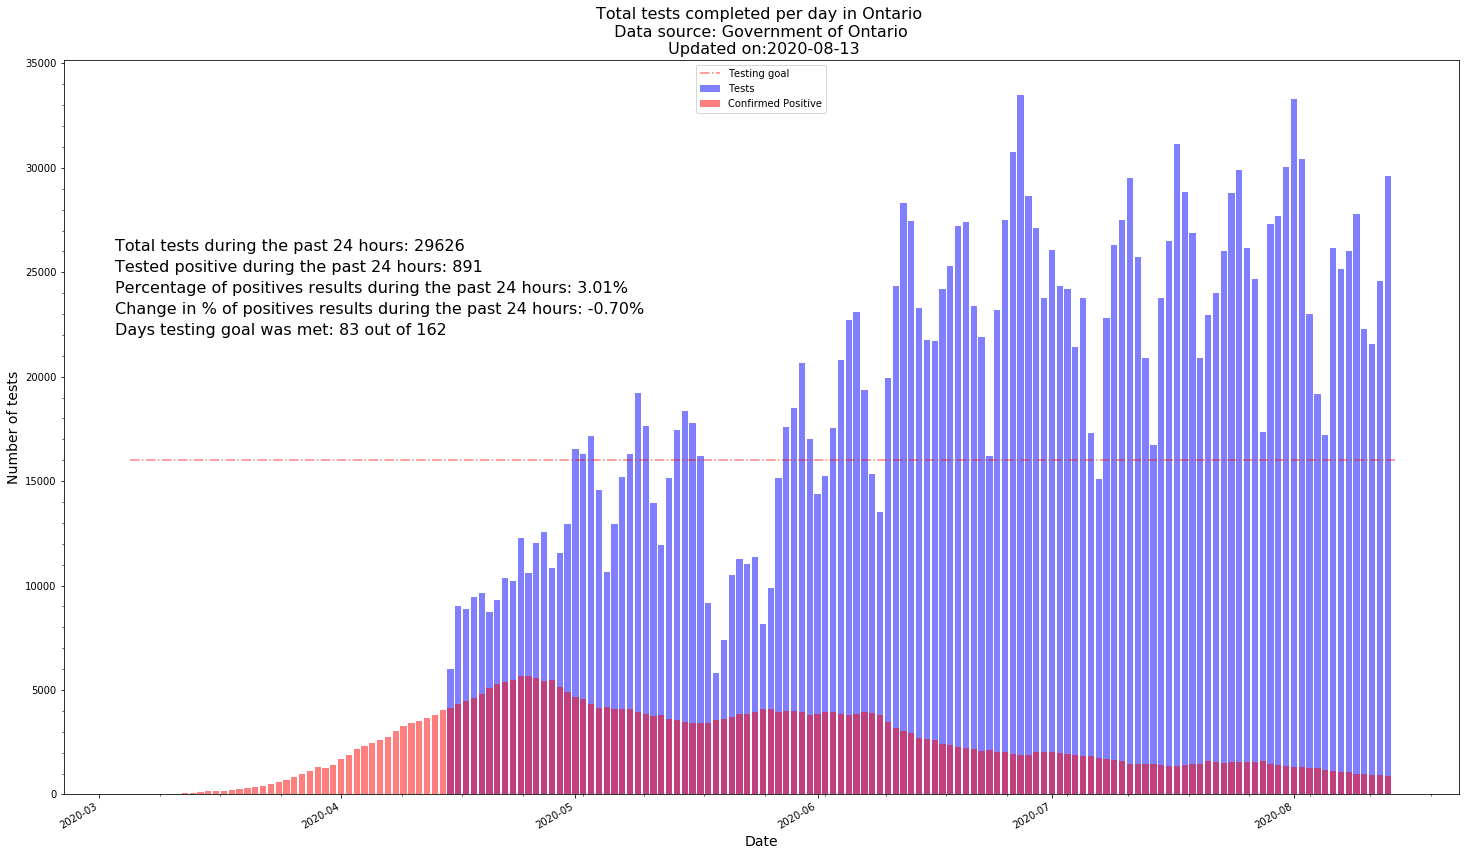

In [17]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Total tests completed in the last day'], label='Tests', color='blue', alpha=0.5)
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Confirmed Positive'], label='Confirmed Positive', color='red', alpha=0.5)
ax.text(x=dt.datetime(2020,3,3), y=26000,s='Total tests during the past 24 hours: '+'{0:.0f}'.format(((Ontario_confirmed_df['Total tests completed in the last day'][-1]))), fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=25000,s='Tested positive during the past 24 hours: '+'{0:.0f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]))), fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=24000,s='Percentage of positives results during the past 24 hours: '+'{0:.2f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]/Ontario_confirmed_df['Total tests completed in the last day'][-1]))*100)+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=23000,s='Change in % of positives results during the past 24 hours: '+'{0:.2f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]/Ontario_confirmed_df['Total tests completed in the last day'][-1])-(Ontario_confirmed_df['Confirmed Positive'][-2]/Ontario_confirmed_df['Total tests completed in the last day'][-2]))*100)+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=22000,s='Days testing goal was met: '+str(ON_testing_goal_met)+' out of '+str(len(Ontario_confirmed_df)), fontsize=16)
#ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Confirmed Negative'], label='Confirmed Negative', color='red', alpha=0.3)
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of tests', fontsize=14)
plt.title('Total tests completed per day in Ontario \n Data source: Government of Ontario \n Updated on:'+str(dt.date.today()), fontsize=16)
plt.minorticks_on()
plt.hlines(16000, dt.datetime(2020,3,5), dt.datetime.today(), color='red', label='Testing goal', linestyles='dashdot', alpha=0.5) #Displaying a horizontal dash line across the graph
plt.legend(loc='upper center')

plt.show()

## Plotting cumulative, active, and resolved cases in Ontario
## Note that active cases are calculated as Cumulative cases - resolved cases - deaths

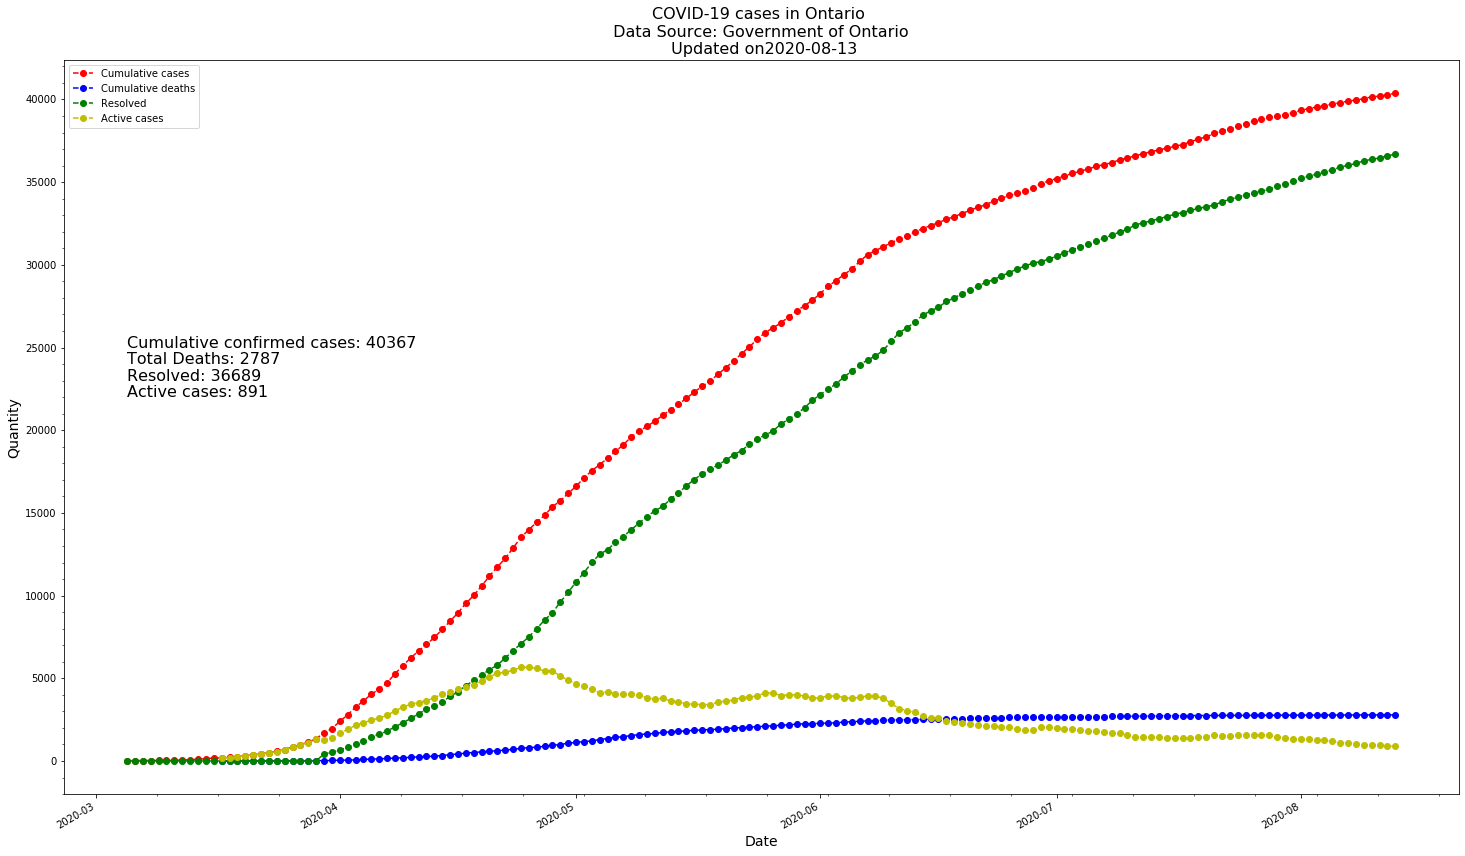

In [18]:
fig, ax=plt.subplots(figsize=(25,15))
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_cases, 'ro--', label='Cumulative cases')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_deaths, 'bo--', label='Cumulative deaths')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Resolved'],  'go--', label='Resolved')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_cases-Ontario_confirmed_df['Resolved']-Ontario_confirmed_df.Cumulative_deaths, 'yo--', label='Active cases')
ax.text(x=dt.datetime(2020,3,5), y=25000,s='Cumulative confirmed cases: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=24000,s='Total Deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=23000,s='Resolved: '+str('{0:.0f}'.format(Ontario_confirmed_df.Resolved[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=22000,s='Active cases: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1]-Ontario_confirmed_df['Resolved'][-1]-Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
plt.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.title('COVID-19 cases in Ontario \n Data Source: Government of Ontario \n Updated on'+str(dt.date.today()), fontsize=16)
plt.minorticks_on()
#plt.grid(which='major')
plt.show()

## We plot the daily new cases of infections and deaths in Ontario Province using matplotlib. In order to metigate day-to-day fluctuations, the blue line tracks a 7-days rolling average of new infections to show a more general trend of the 'curve' which appears to be on the downward trend since April 15. A few texts combined with variables are also plotted on the chart to reflect important changes such as change in new infections and deaths. 


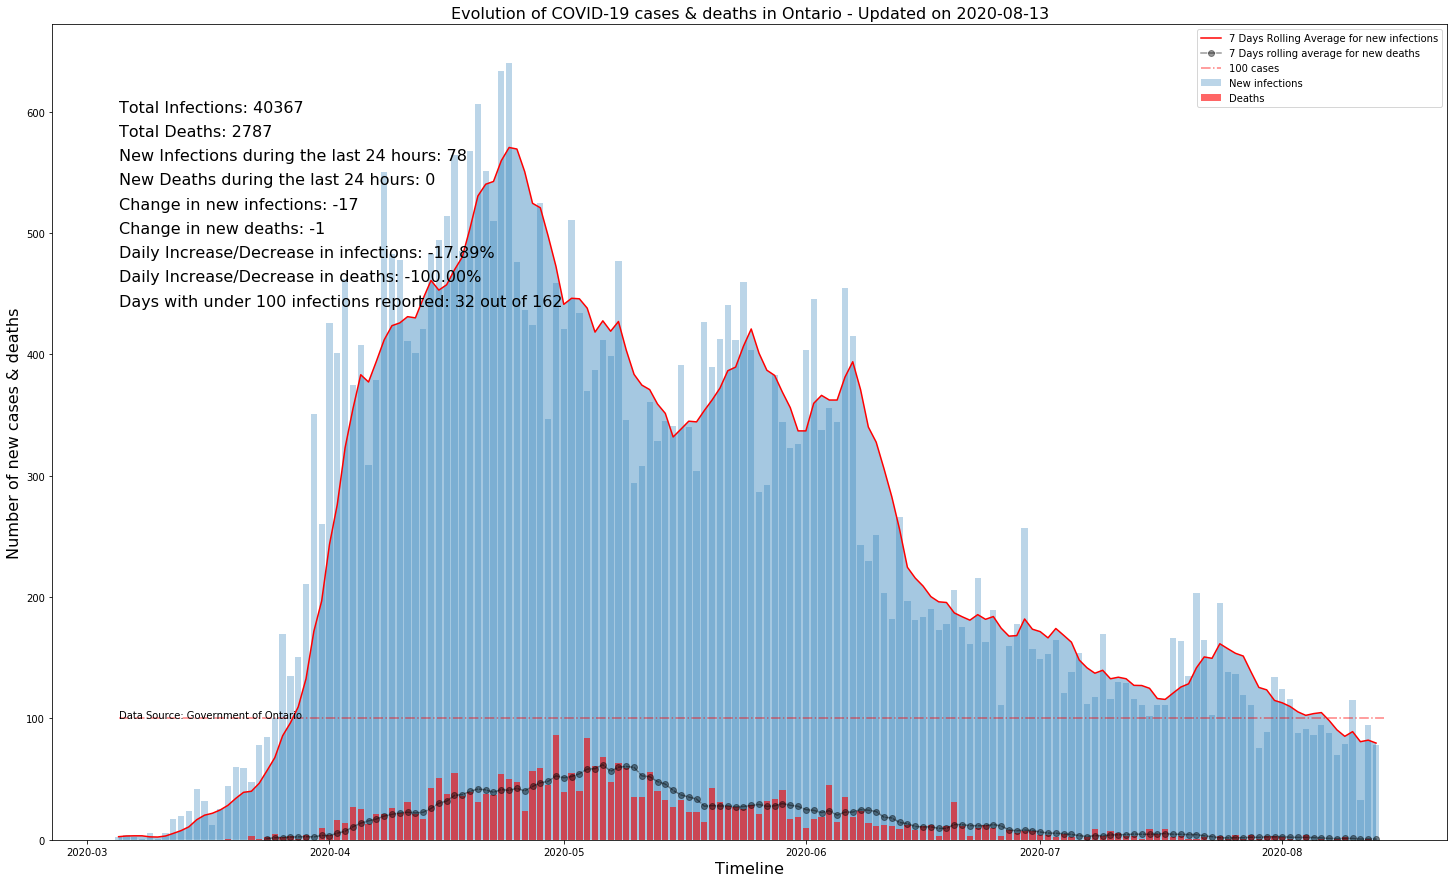

In [49]:
#pd.date_range(start='2020-01-22', periods=len(Ontario_confirmed_df), freq='D')
fig, ax=plt.subplots(figsize=(25,15))
ax.xaxis_date()
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases, alpha=0.3, label='New infections')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.stackplot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases_MA7, labels=[], alpha=0.4 )
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases_MA7, color='red', label= '7 Days Rolling Average for new infections')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_deaths_MA7, 'ko--', dash_capstyle='projecting', alpha=0.4, label='7 Days rolling average for new deaths' )
ax.text(x=dt.datetime(2020,3,5), y=600,s='Total Infections: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=580,s='Total Deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=560,s='New Infections during the last 24 hours: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=540,s='New Deaths during the last 24 hours: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=520,s='Change in new infections: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_cases[-1]-Ontario_confirmed_df.New_cases[-2])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=500,s='Change in new deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_deaths[-1]-Ontario_confirmed_df.New_deaths[-2])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=480,s='Daily Increase/Decrease in infections: '+'{0:.2f}'.format(((Ontario_confirmed_df.New_cases[-1]-Ontario_confirmed_df.New_cases[-2])/Ontario_confirmed_df.New_cases[-2]*100))+'%', fontsize=16) # Note the use of the format() method to round the percentage decimals
ax.text(x=dt.datetime(2020,3,5), y=460,s='Daily Increase/Decrease in deaths: '+'{0:.2f}'.format(((Ontario_confirmed_df.New_deaths[-1]-Ontario_confirmed_df.New_deaths[-2])/Ontario_confirmed_df.New_deaths[-2]*100))+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=440,s='Days with under 100 infections reported: '+str(ON_days_under_100_cases)+' out of '+str(len(Ontario_confirmed_df)), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=100,s='Data Source: Government of Ontario')
#fig.autofmt_xdate()
#ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
#ax.fmt_xdata = mdates.date_ticker_factory()
#plt.tight_layout()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.hlines(100, dt.datetime(2020,3,5), dt.datetime.today(), color='red', label='100 cases', linestyles='dashdot', alpha=0.5) #Displaying a horizontal dash line across the graph
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in Ontario - Updated on '+str(dt.date.today()), fontsize=16)
plt.savefig('COVID19ON.pdf', bbox_inches='tight') # This code saves the plot to a PDF file
plt.show()

## The below chart is generated with Plotly Express library, with a main advantage that it's an interactive chart and easy to generate mainly inteded for tidy date! Just hover the mouse over the chart and you will be able to read the details of each day & many other functions!

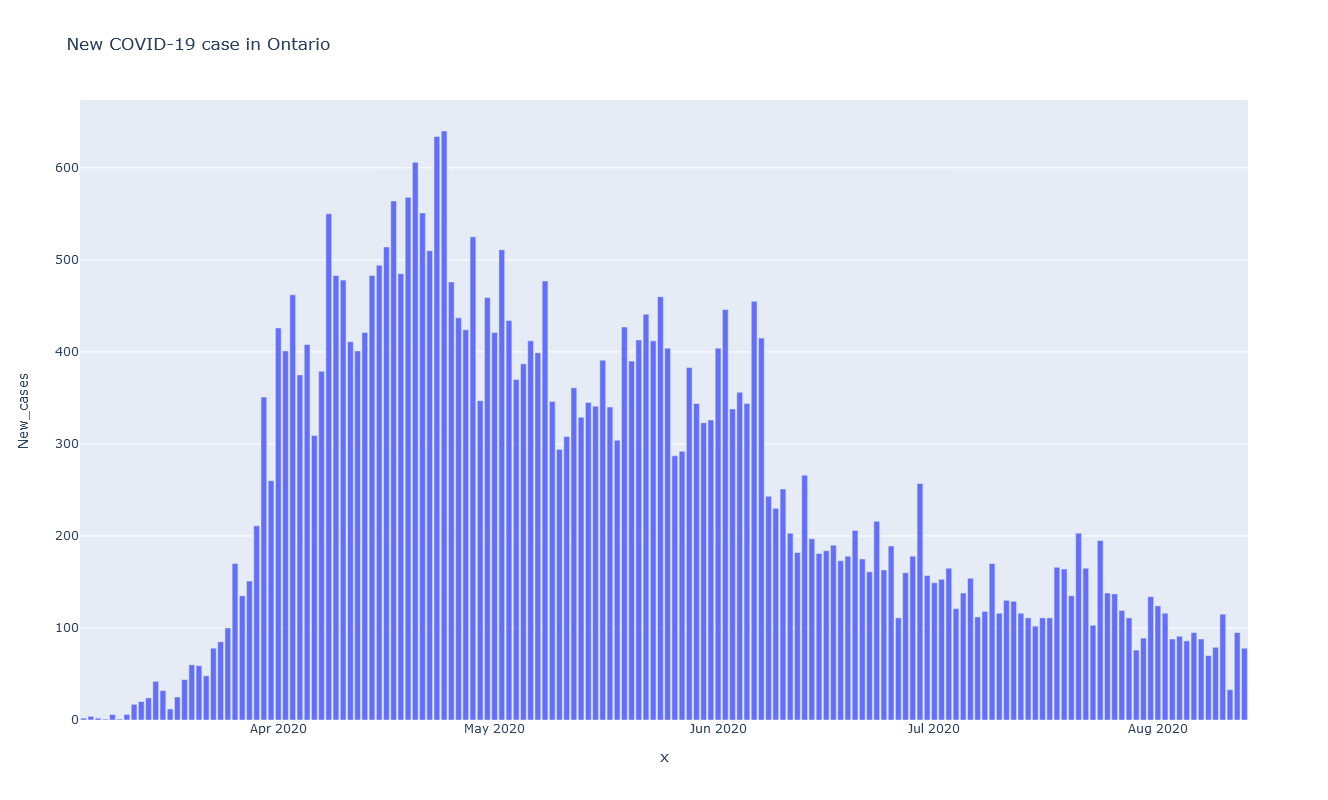

In [20]:
fig = px.bar(data_frame=Ontario_confirmed_df, x=Ontario_confirmed_df.index, y='New_cases', title='New COVID-19 case in Ontario', width=1400, height= 800)
fig.show()

## This chart is done using the standard Plotly library using the 'go.Figure' method. This was allows us to use multiple layers as illustrated-below

In [21]:
fig=go.Figure()
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_cases, name='Infections'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_deaths, name='Deaths'))
fig.add_trace(go.Scatter(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_cases_MA7, name='7-Days rolling average'))
fig.update_layout(title='Daily new infections and deaths in Ontario', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)
py.plot(fig, filename='Covid-Ontario')


'https://plotly.com/~ralhusban/4/'

In [22]:
fig=go.Figure(skip_invalid=True)
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients hospitalized with COVID-19'], name='Hospitalizations'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients in ICU with COVID-19'], name='Patients in ICU'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'], name='Intubated'))
fig.update_layout(title='Onatario hospitalizations with COVID-19', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)
py.plot(fig, filename='Ontario_Covid19')


'https://plotly.com/~ralhusban/22/'

## A word of caution on both models attempted below: The Data that trained the model is very limited to produce a reliable model. Also a significant downside is that our only variable is the number of new infections. More advances and successful models take into account many variables such as how a population adheres to social distancing, the R^0 of the contagion, etc.

## Prophet (Built by Facebook). This library required your dataframe to have a date column called 'ds' and a 'y' column containing the numeric data you want to fit the model with. Hence we do some manipulations with our dataframe to make sure it fits the requirement.

In [23]:
test_df=Ontario_confirmed_df[['New_cases']] # Since the dataframe's index is the date, we only need the new cases column

In [24]:
test_df.rename(columns={'New_cases':'y'}, inplace=True)
test_df['ds']=test_df.index # Copied the index to the 'ds' date column as required by Prophet

C:\Users\amg_m\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## We initialize the Prophet forecasting procedure below. Notice that there are two growth options, logistic, and linear. The logistic growth did not fit the needs of an epidimiological model hence we opted for the default linear option while enabling the MCMC parameter (Markov Chain Monte Carlo) which allows us to include seasonal uncertanties and a full Baysian sampling.

In [25]:
m=Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, mcmc_samples=300) #Initiated a Prophet instance, and disabling all three parameters of seasonality

In [26]:
m.fit(test_df) # Model is fit with the dataframe e.g. trained

In [27]:
future=m.make_future_dataframe(periods=90) # A very useful function which builds a new dataframe with future dates to integrate the forcasted data. Here we chose to go 30 days into the future.

In [28]:
forecast = m.predict(future) # We initiated forecasting and passed the future dataframe as a parameter
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds        yhat  yhat_lower  yhat_upper
247 2020-11-07 -217.211445 -508.331175   59.433013
248 2020-11-08 -220.347723 -504.963477   52.992738
249 2020-11-09 -223.484002 -518.943945   47.375911
250 2020-11-10 -226.620281 -523.517526   62.685976
251 2020-11-11 -229.756559 -521.487492   58.194933

In [29]:
forecast.head(-20)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2020-03-05  -38.156126 -127.120385   53.025932   -64.250328   -10.782277   
1   2020-03-06  -26.149724 -116.935857   61.226779   -51.154894     0.442772   
2   2020-03-07  -14.143323  -98.506490   77.230783   -38.281070    11.371079   
3   2020-03-08   -2.136922  -88.562676   86.176659   -25.507641    22.370854   
4   2020-03-09    9.869480  -76.529651   97.743788   -12.678787    33.792791   
..         ...         ...         ...         ...          ...          ...   
227 2020-10-18 -154.485872 -354.530267   32.465773  -344.889964    13.837160   
228 2020-10-19 -157.622151 -368.324702   36.653757  -352.570950    14.450062   
229 2020-10-20 -160.758429 -369.914592   33.484826  -359.596898    15.566643   
230 2020-10-21 -163.894708 -384.346167   38.895302  -367.257301    16.967314   
231 2020-10-22 -167.030987 -389.549964   32.064381  -375.049662    17.114587   

     additive_terms  additive_terms_lower  additive_terms_upper  \
0               0.0                   0.0                   0.0   
1               0.0                   0.0                   0.0   
2               0.0                   0.0                   0.0   
3               0.0                   0.0                   0.0   
4               0.0                   0.0                   0.0   
..              ...                   ...                   ...   
227             0.0                   0.0                   0.0   
228             0.0                   0.0                   0.0   
229             0.0                   0.0                   0.0   
230             0.0                   0.0                   0.0   
231             0.0                   0.0                   0.0   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
227                   0.0                         0.0   
228                   0.0                         0.0   
229                   0.0                         0.0   
230                   0.0                         0.0   
231                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0  -38.156126  
1                           0.0  -26.149724  
2                           0.0  -14.143323  
3                           0.0   -2.136922  
4                           0.0    9.869480  
..                          ...         ...  
227                         0.0 -154.485872  
228                         0.0 -157.622151  
229                         0.0 -160.758429  
230                         0.0 -163.894708  
231                         0.0 -167.030987  

[232 rows x 13 columns]

## Below plot illustrates the actual data in purple dotted line while the solid lines represented the upper, lower, and mid y_hat (forecast) ranges generated by the Prophet.
## The sharp increase in cases and deaths on May 6th destabilized the model. This is caused by the NYT starting to report probable COVID-19 cases and deaths and not only the ones confirmed by testing.

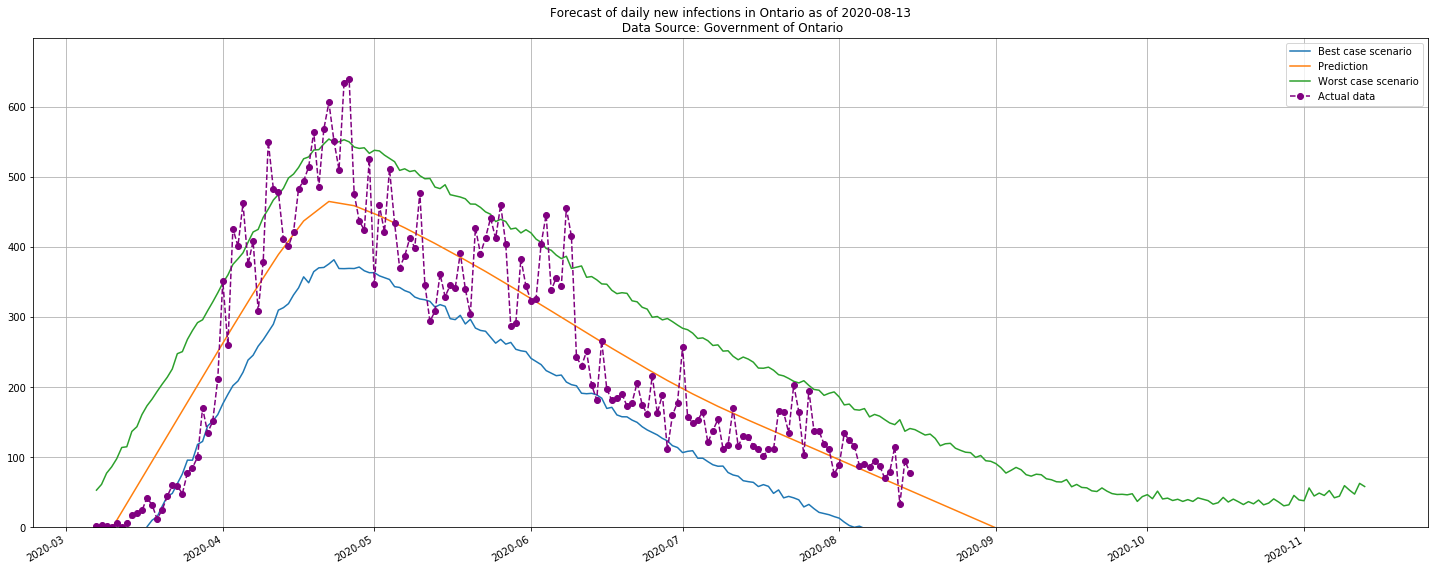

In [30]:
fig, ax=plt.subplots(figsize=(25,10))
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'), forecast.yhat_lower, label='Best case scenario')
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'),forecast.yhat, label='Prediction')
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'), forecast.yhat_upper, label='Worst case scenario')
plt.plot(pd.date_range(start='2020-03-07', periods=len(test_df), freq='D'), test_df.y,  'o--', label='Actual data', color='purple')
plt.title('Forecast of daily new infections in Ontario as of '+ str(dt.date.today()) + '\n Data Source: Government of Ontario')
plt.legend()
plt.grid()
#plt.hlines(y=0, xmin=0, xmax=len(future), color='red')
plt.ylim(bottom=0)
fig.autofmt_xdate()
plt.show()

## The below plot is built-in in the Prophet, it illustrates the same data

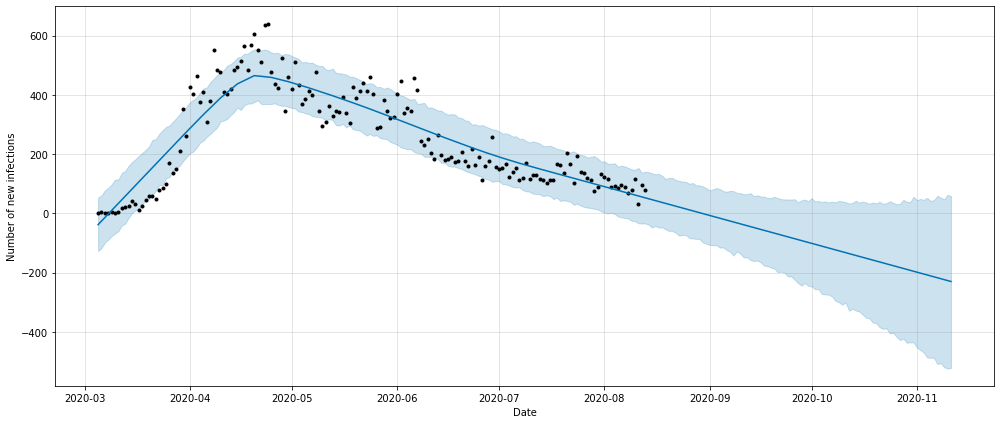

In [31]:
fig1=m.plot(forecast.iloc[:1500], figsize=(14,6), xlabel='Date', ylabel='Number of new infections')

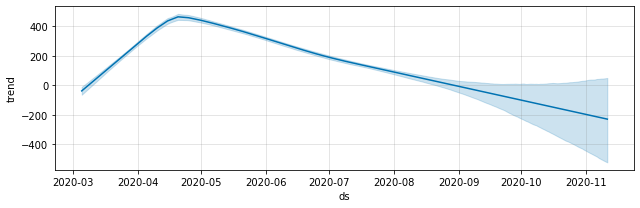

In [32]:
fig=m.plot_components(forecast)

In [33]:
Ontario_clinic_data.sort_values(by=['Accurate_Episode_Date'], ascending=True, inplace=True)
Ontario_clinic_data['Accurate_Episode_Date']=pd.to_datetime(Ontario_clinic_data.Accurate_Episode_Date)

In [34]:
Ontario_clinic_data

Row_ID Accurate_Episode_Date Case_Reported_Date Test_Reported_Date  \
3078     3079            2019-12-25         2020-03-29         2020-03-29   
13813   13814            2020-01-01         2020-04-24         2020-04-24   
18853   18854            2020-01-01         2020-05-17         2020-05-17   
23162   23163            2020-01-10         2020-06-10         2020-06-10   
633       634            2020-01-21         2020-01-23         2020-01-27   
...       ...                   ...                ...                ...   
27281   27282            2020-08-12         2020-08-12         2020-08-12   
616       617            2020-08-12         2020-08-12         2020-08-12   
488       489            2020-08-12         2020-08-12         2020-08-12   
27550   27551                   NaT         2020-04-17         2020-04-17   
33100   33101                   NaT         2020-06-09         2020-06-09   

      Specimen_Date Age_Group Client_Gender Case_AcquisitionInfo  \
3078            NaN       70s          MALE          No Epi-link   
13813    2020-04-23       80s          MALE          No Epi-link   
18853    2020-05-15       50s          MALE                   CC   
23162    2020-06-09       50s          MALE                   CC   
633      2020-01-23       50s          MALE               Travel   
...             ...       ...           ...                  ...   
27281    2020-08-11       60s          MALE      No Info-Missing   
616             NaN       20s        FEMALE          No Epi-link   
488      2020-08-11       60s          MALE          No Epi-link   
27550    2020-04-15   UNKNOWN          MALE          No Epi-link   
33100    2020-06-08   UNKNOWN        FEMALE                   OB   

           Outcome1 Outbreak_Related  \
3078       Resolved              NaN   
13813      Resolved              NaN   
18853      Resolved              NaN   
23162      Resolved              NaN   
633        Resolved              NaN   
...             ...              ...   
27281  Not Resolved              NaN   
616    Not Resolved              Yes   
488    Not Resolved              Yes   
27550      Resolved              NaN   
33100      Resolved              Yes   

                                  Reporting_PHU  \
3078         York Region Public Health Services   
13813             Haldimand-Norfolk Health Unit   
18853         Region of Waterloo, Public Health   
23162             Haldimand-Norfolk Health Unit   
633                       Toronto Public Health   
...                                         ...   
27281   Niagara Region Public Health Department   
616    Wellington-Dufferin-Guelph Public Health   
488                          Peel Public Health   
27550                     Toronto Public Health   
33100                     Toronto Public Health   

                Reporting_PHU_Address Reporting_PHU_City  \
3078               17250 Yonge Street          Newmarket   
13813             12 Gilbertson Drive             Simcoe   
18853          99 Regina Street South           Waterloo   
23162             12 Gilbertson Drive             Simcoe   
633    277 Victoria Street, 5th Floor            Toronto   
...                               ...                ...   
27281        1815 Sir Isaac Brock Way            Thorold   
616               160 Chancellors Way             Guelph   
488            7120 Hurontario Street        Mississauga   
27550  277 Victoria Street, 5th Floor            Toronto   
33100  277 Victoria Street, 5th Floor            Toronto   

      Reporting_PHU_Postal_Code  \
3078                    L3Y 6Z1   
13813                   N3Y 4N5   
18853                   N2J 4V3   
23162                   N3Y 4N5   
633                     M5B 1W2   
...                         ...   
27281                   L2V 4T7   
616                     N1G 0E1   
488                     L5W 1N4   
27550                   M5B 1W2   
33100                   M5B 1W2   

                             

In [35]:
#Grouped_Ontario_Clinic_Data=Ontario_clinic_data.groupby(['Reporting_PHU','Reporting_PHU_Latitude', 'Reporting_PHU_Longitude', 'Outcome1'], ).agg(['count'])['Reporting_PHU_City'].sort_values(by=['Reporting_PHU'],ascending=True)
Grouped_Ontario_Clinic_Data=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Outcome1'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
Grouped_Ontario_Clinic_Data_case_source=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Case_AcquisitionInfo'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
Grouped_Ontario_Clinic_Data_age_group=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Age_Group'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})

In [36]:

unresolved_df=Grouped_Ontario_Clinic_Data[Grouped_Ontario_Clinic_Data.Outcome1=='Not Resolved'].sort_values(by='Row_ID', ascending=False)

In [37]:
unresolved_df.rename(columns={'Outcome1':'Status','Row_ID':'Qty'}, inplace=True)

In [38]:
unresolved_df.head(15)

Reporting_PHU_City        Status  Qty  Reporting_PHU_Latitude  \
76            Toronto  Not Resolved  156               43.656591   
28        Mississauga  Not Resolved  144               43.647471   
40             Ottawa  Not Resolved  129               45.345665   
85            Windsor  Not Resolved   93               42.308796   
11            Chatham  Not Resolved   74               42.403861   
32          Newmarket  Not Resolved   61               44.048023   
59         St. Thomas  Not Resolved   53               42.777804   
20           Hamilton  Not Resolved   29               43.257631   
68            Thorold  Not Resolved   26               43.116537   
79           Waterloo  Not Resolved   21               43.462876   
37           Oakville  Not Resolved   19               43.413997   
82             Whitby  Not Resolved   16               43.898605   
25             London  Not Resolved   16               42.981468   
17             Guelph  Not Resolved   11               43.524881   
1              Barrie  Not Resolved    9               44.410713   

    Reporting_PHU_Longitude  
76               -79.379358  
28               -79.708893  
40               -75.763912  
85               -83.033670  
11               -82.208561  
32               -79.480239  
59               -81.151156  
20               -79.871341  
68               -79.241220  
79               -80.520913  
37               -79.744796  
82               -78.940341  
25               -81.254016  
17               -80.233743  
1                -79.686306

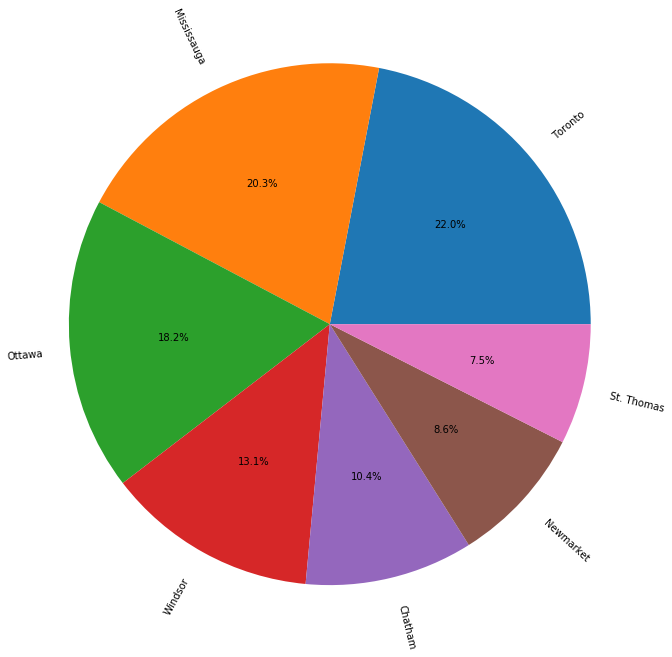

In [39]:
plt.pie(unresolved_df.Qty[unresolved_df.Qty>30], labels=unresolved_df.Reporting_PHU_City[unresolved_df.Qty>30], radius=3, rotatelabels=True, autopct='%1.1f%%')
plt.show()

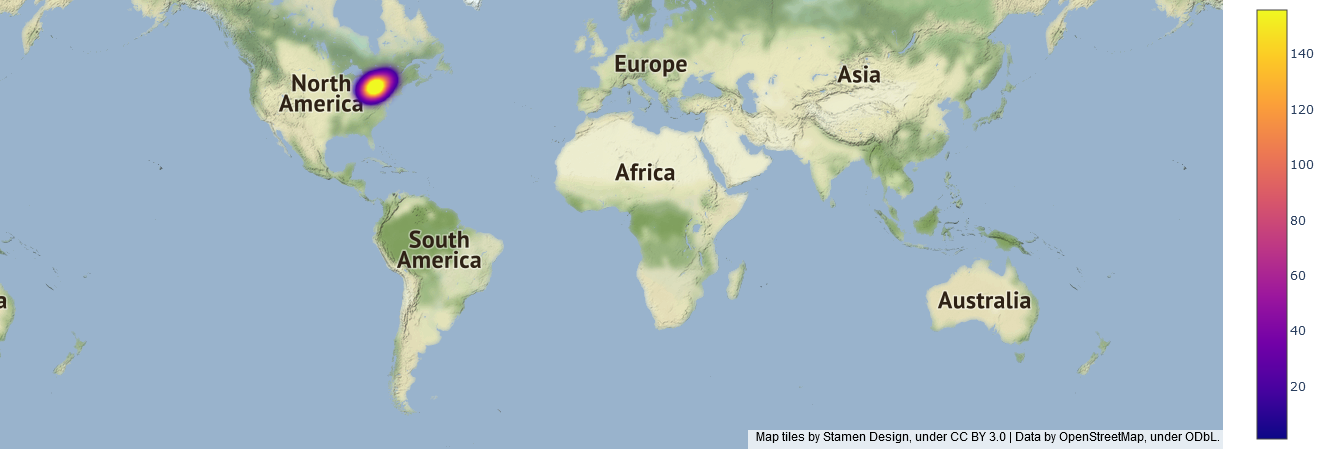

In [40]:
fig = go.Figure(go.Densitymapbox(lat=unresolved_df.Reporting_PHU_Latitude, lon=unresolved_df.Reporting_PHU_Longitude, z=unresolved_df.Qty,
                                 radius=20))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=3)
fig.update_layout(margin={"r":10,"t":0,"l":0,"b":1})
fig.show()

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



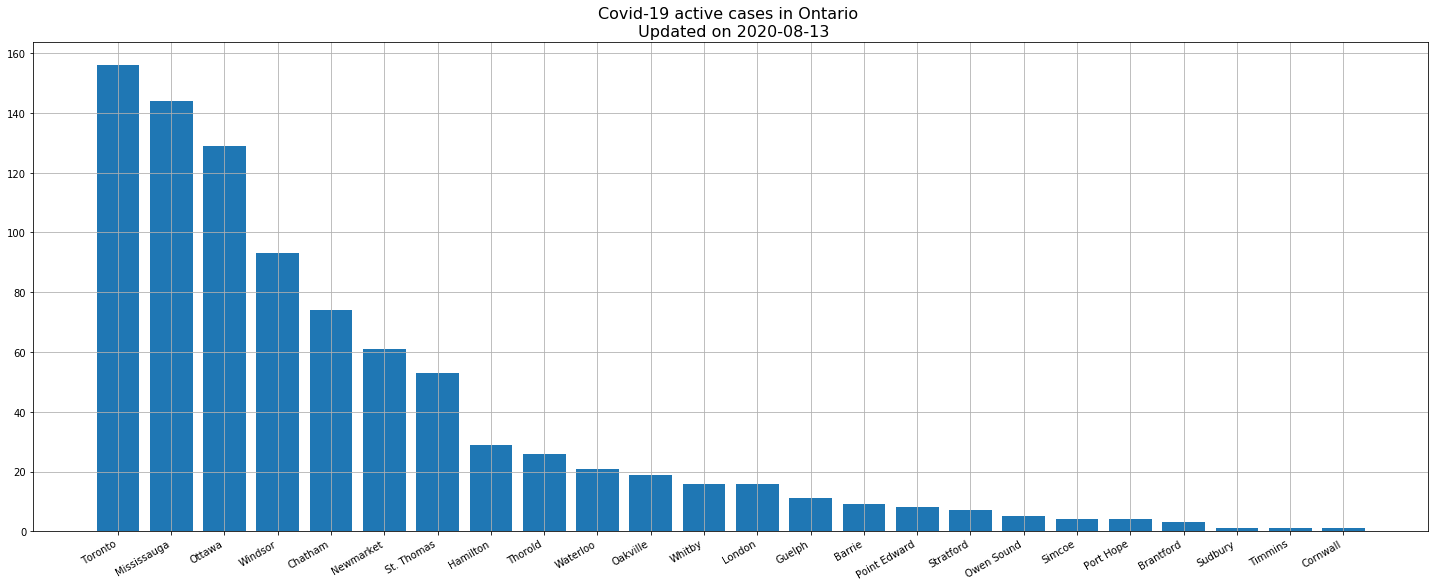

In [41]:
fig, ax=plt.subplots(figsize=(25,10))
plt.bar(unresolved_df.Reporting_PHU_City, unresolved_df.Qty)
fig.autofmt_xdate()
plt.grid()
plt.title('Covid-19 active cases in Ontario \n Updated on '+str(dt.date.today()), fontsize=16)
fig.show()



In [42]:
active_by_age_group=Grouped_Ontario_Clinic_Data_age_group.sort_values(by='Row_ID', ascending=False)

In [43]:
active_age_group_Toronto=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Toronto']
active_age_group_Missisauga=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Missisauga']
active_age_group_Ottawa=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Ottawa']
active_age_group_Oakville=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Oakville']
active_age_group_Hamilton=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Hamilton']

ValueError: shape mismatch: objects cannot be broadcast to a single shape

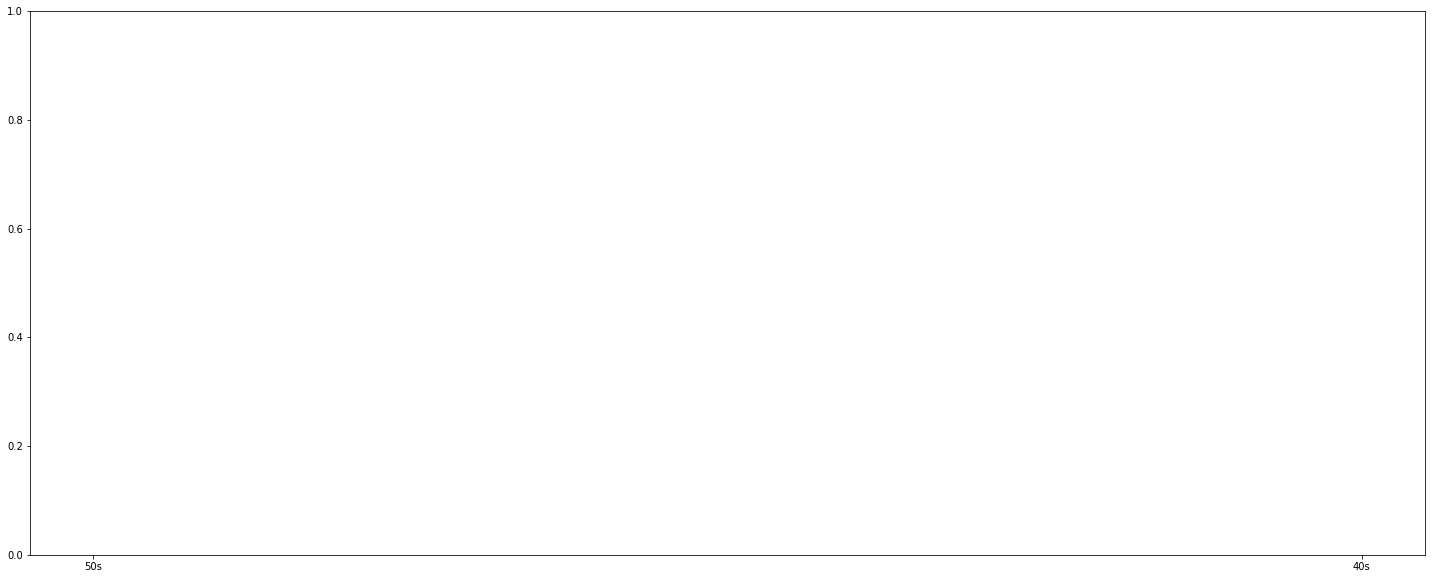

In [44]:
fig, ax=plt.subplots(figsize=(25,10))
plt.bar(active_age_group_Toronto.Age_Group, active_age_group_Hamilton.Row_ID)
fig.autofmt_xdate()
plt.grid()
plt.title('Covid-19 active cases age groups in Ontario \n Updated on '+str(dt.date.today()), fontsize=16)
fig.show()


In [ ]:
active_by_age_group

In [ ]:
active_by_age_group[['Reporting_PHU_City','Age_Group','Row_ID']].groupby(['Reporting_PHU_City']).get_group('Toronto').plot(kind='bar', x='Age_Group', figsize=(15,10), title='Number of cases by age group in Mississauga')
#Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Case_AcquisitionInfo'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
